In [86]:
pip install tensorflow --upgrade

  Attempting uninstall: google-auth
    Found existing installation: google-auth 1.33.0
    Uninstalling google-auth-1.33.0:
      Successfully uninstalled google-auth-1.33.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'C:\\Users\\Julio.Rena\\Anaconda3\\Lib\\site-packages\\google\\~rotobuf\\internal\\_api_implementation.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [48]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import callbacks

## Import Dataset

In [22]:
dataset_dir = r'C:\Users\Julio.Rena\Downloads\gender'

dataset_train_dir = os.path.join(dataset_dir, 'Training')
dataset_train_female_len = len(os.listdir(os.path.join(dataset_train_dir, 'female' )))
dataset_train_male_len = len(os.listdir(os.path.join(dataset_train_dir, 'male' )))

dataset_validation_dir = os.path.join(dataset_dir, 'Validation')
dataset_validation_female_len = len(os.listdir(os.path.join(dataset_validation_dir, 'female' )))
dataset_validation_male_len = len(os.listdir(os.path.join(dataset_train_dir, 'male' )))

print('Train female: %s' %dataset_train_female_len)
print('Train male: %s' %dataset_train_male_len)
print('Validation female: %s' %dataset_validation_female_len)
print('Train male: %s' %dataset_validation_male_len)

Train female: 23243
Train male: 23766
Validation female: 5841
Train male: 23766


### Criando variáveis que servirão como parâmetros para tratar as imagens

In [26]:
image_width = 160
image_heigh = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_heigh)
image_shape = image_size + (image_color_channel,)

batch_size = 32
epochs = 20
learning_rate = 0.0001

class_names = ['female', 'male']

### Pre Processamento das imagens de treino e validação

In [28]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True)

Found 47009 files belonging to 2 classes.


In [29]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True)

Found 11649 files belonging to 2 classes.


In [30]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: %d' %tf.data.experimental.cardinality(dataset_test))

Validation Dataset Cardinality: 292
Test Dataset Cardinality: 73


### Visualizando as imagens e suas classes no dataset de treino e teste

In [37]:
def plot_dataset(dataset):
    plt.gcf().clear()
    plt.figure(figsize=(15,15))
    
    for features, labels in dataset.take(1):
        for i in range(9):
            plt.subplot(3,3,i + 1)
            plt.axis('off')
            
            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
    

<Figure size 432x288 with 0 Axes>

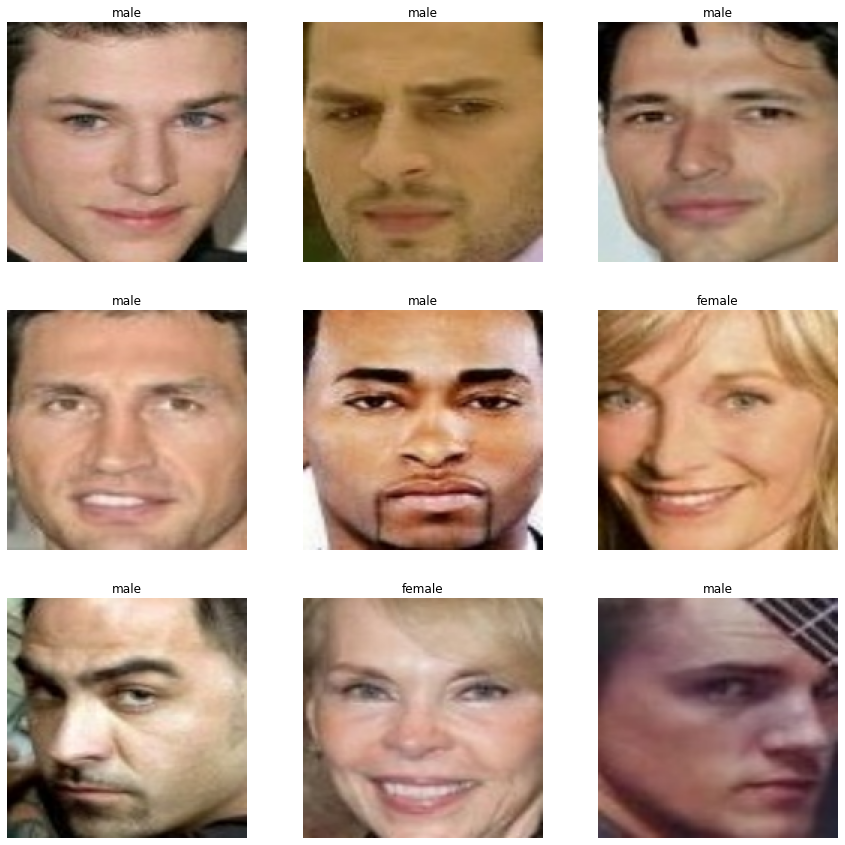

In [38]:
plot_dataset(dataset_train)

<Figure size 432x288 with 0 Axes>

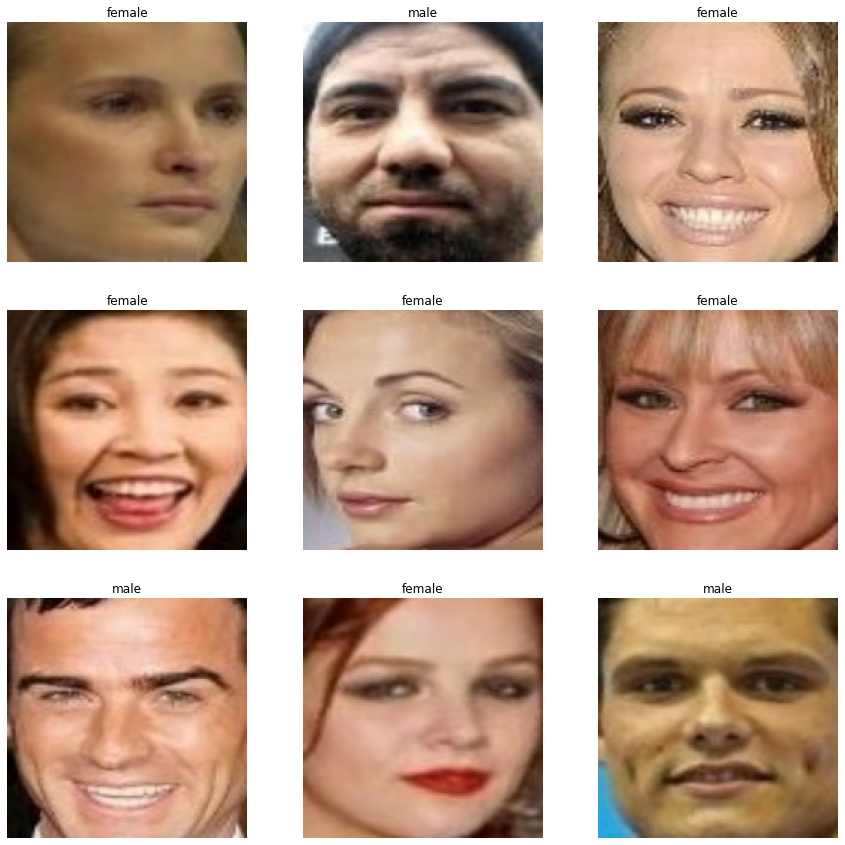

In [39]:
plot_dataset(dataset_test)

### Criando o modelo sequencial com 3 camadas de rede

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling
    (1. / image_color_channel_size,
     input_shape = image_shape
    ),
    tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

### Compilando o modelo

In [44]:
 model.compile(
     optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
     loss = tf.keras.losses.BinaryCrossentropy(),
     metrics = ['accuracy']
 )
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        1

### Treinando o modelo com 20 epochs

In [49]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

history = model.fit(
dataset_train,
validation_data = dataset_validation,
epochs = epochs,
callbacks=[earlystopping])

Epoch 1/20
1470/1470 [==============================] - 582s 396ms/step - loss: 0.1175 - accuracy: 0.9575 - val_loss: 0.1223 - val_accuracy: 0.9551
Epoch 2/20
1470/1470 [==============================] - 568s 386ms/step - loss: 0.1083 - accuracy: 0.9603 - val_loss: 0.1285 - val_accuracy: 0.9516
Epoch 3/20
1470/1470 [==============================] - 533s 362ms/step - loss: 0.0998 - accuracy: 0.9636 - val_loss: 0.1157 - val_accuracy: 0.9578
Epoch 4/20
1470/1470 [==============================] - 535s 363ms/step - loss: 0.0913 - accuracy: 0.9671 - val_loss: 0.1519 - val_accuracy: 0.9407
Epoch 5/20
1470/1470 [==============================] - 544s 370ms/step - loss: 0.0847 - accuracy: 0.9697 - val_loss: 0.1474 - val_accuracy: 0.9433
Epoch 6/20
1470/1470 [==============================] - 536s 364ms/step - loss: 0.0774 - accuracy: 0.9724 - val_loss: 0.1113 - val_accuracy: 0.9592
Epoch 7/20
1470/1470 [==============================] - 553s 376ms/step - loss: 0.0697 - accuracy: 0.9752 - val_

### Função para plotar os resultados e as previsões no dataset de teste

In [50]:
def plot_dataset_predictions(dataset):
    
    features, labels = dataset.as_numpy_iterator().next()
    
    predictions = model.predict_on_batch(features).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)
    
    print('Labels: %s' %labels)
    print('Predictions: %s' %predictions.numpy())
    
    plt.gcf().clear()
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        plt.subplot(3, 3, i + 1 )
        plt.axis('off')
        
        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]])
    

Labels: [1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0]
Predictions: [1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0]


<Figure size 432x288 with 0 Axes>

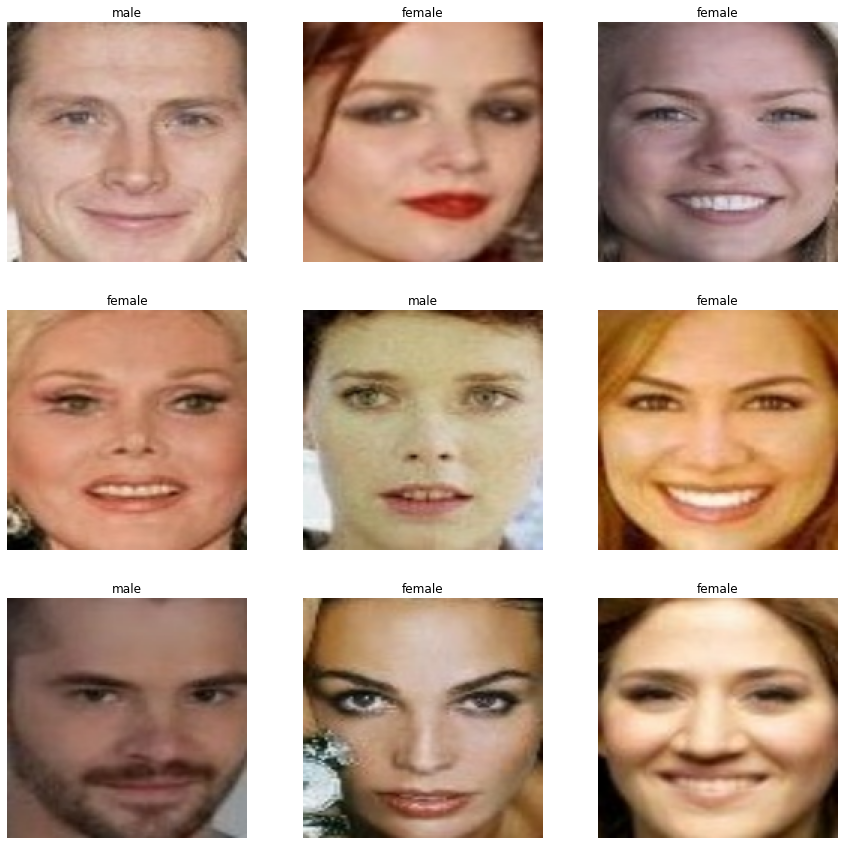

In [51]:
plot_dataset_predictions(dataset_test)

### Visualização da performance do modelo

In [72]:
def plot_model():
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
   
    
    epochs_range = range(11)
    
    plt.gcf().clear()
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label = 'Training accuracy')
    plt.plot(epochs_range, val_accuracy, label = 'Validation accuracy')
    plt.legend(loc = 'lower right')
    
    plt.subplot(1,2,2)
    plt.title('Training and validation Loss')
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'lower right')
    
    plt.show()
    

<Figure size 432x288 with 0 Axes>

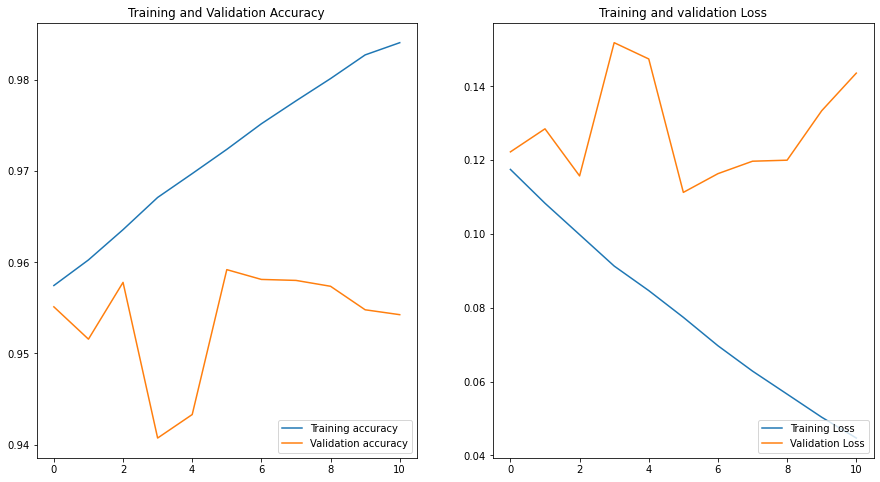

In [73]:
plot_model()

#Possível Overfitting, pois ele aprendeu muito com o treino mas na validação não teve um desempenho tão satisfatório quanto.

### Otimizando o modelo com data_augmentation e model_transfer_learning

#Data_augmentation não será usado pela quantidade excessiva de imagens

In [79]:
#Método para aumentar o dataset, fazendo distorções e movimentos da mesma imagem


# data_augmentation = tf.keras.models.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
# ])

# def plot_dataset_data_augmentation(dataset):
    
#     plt.gcf().clear()
#     plt.figure(figsize=(15,5))
    
#     for features, _ in dataset.take(1):
        
#         feature = features[0]
        
#         for i in range(9):
#             feature_data_augmentation = data_augmentation(tf.expand_dims(feature,0))
            
#             plt.subplot(3, 3, i + 1)
#             plt.axis('off')
            
#             plt.imshow(feature_data_augmentation[0] / image_color_channel_size)


#plot_dataset_data_augmentation(dataset_train)

In [89]:
model_transfer_learning = tf.keras.applications.MobileNetV2( input_shape = image_shape, include_top = False, weights = 'imagenet')

model_transfer_learning.treinable = False
model_transfer_learning.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [93]:
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling
    (1. / image_color_channel_size,
     input_shape = image_shape
    ),
    model_transfer_learning,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [94]:
 model.compile(
     optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
     loss = tf.keras.losses.BinaryCrossentropy(),
     metrics = ['accuracy']
 )
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 2,225,153
No

In [ ]:
#Earlystopping para monitorar as épocas e onto em que o a diferença do custo não vai ser tao significante, para aí parar o treinamento
earlystopping = callbacks.EarlyStopping(monitor="loss",
                                        mode="min", patience=3,
                                        restore_best_weights=True)

history = model.fit(
dataset_train,
validation_data = dataset_validation,
epochs = epochs,
callbacks=[earlystopping])

Epoch 1/20
1016/1470 [===================>..........] - ETA: 12:08 - loss: 0.1100 - accuracy: 0.9609

### Salvando o modelo

In [52]:
model.save('path/to/model')

INFO:tensorflow:Assets written to: path/to/model\assets


INFO:tensorflow:Assets written to: path/to/model\assets


In [ ]:

#Caso queira usar o modelo futuramente, fazer o upload
model = tf.keras.models.load_model('path/to/model')